# Practice: approximate q-learning

In this notebook you will teach a __PyTorch__ neural network to do Q-learning.

In [2]:
import os
import sys


if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"

Selecting previously unselected package xvfb.
(Reading database ... 155680 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.11_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.11) ...
Setting up xvfb (2:1.19.6-1ubuntu4.11) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [41]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


plt.rcParams['figure.figsize'] = (20, 7)
plt.rcParams['font.size'] = 16

In [42]:
%matplotlib inline

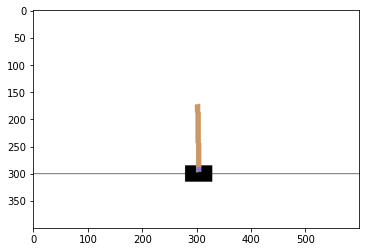

In [43]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
env.close()

In [44]:
n_actions, state_dim

(2, 4)

In [45]:
env.observation_space.shape

(4,)

## Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (`nn.Linear`) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: since agent's observations are not normalized, sigmoids might be saturated at initialization. Instead, use non-saturating nonlinearities like ReLU.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [47]:
network = nn.Sequential()

# YOUR CODE HERE
# Hint: use state_dim as input size and n_actions as output size.
# network.add_module("layer1", ...)

network.add_module('layer1', nn.Linear(state_dim, 128))
network.add_module('activation1', nn.ReLU())
network.add_module('layer2', nn.Linear(128, 64))
network.add_module('activation2', nn.ReLU())
network.add_module('layer3', nn.Linear(64, n_actions))

In [48]:
example_input = torch.from_numpy(env.reset()).type(torch.FloatTensor)

In [49]:
network(example_input)

tensor([0.0554, 0.0067], grad_fn=<AddBackward0>)

In [50]:
state = env.reset()
state = torch.tensor(state[None], dtype=torch.float32)
state.shape

torch.Size([1, 4])

In [51]:
from math import e
import random


def get_action(state, epsilon=0.0):
    state = torch.tensor(state[None], dtype=torch.float32)
    q_values = network(state).detach().numpy()

    # YOUR CODE HERE
    # Sample actions with epsilon-greedy policy, i.e. pick random action
    # with probability of epsilon else pick action with highest Q(s,a).
    # action = ...
    if random.random() < epsilon:
      action = np.random.choice(np.arange(n_actions))
    else:
      action = np.argmax(q_values)

    return int(action)

In [52]:
state = env.reset()
assert tuple(network(torch.tensor([state] * 3, dtype=torch.float32)).size()) == (
    3,
    n_actions,
), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(
    list(network.modules())[-1], nn.Linear
), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(
    get_action(state), int
), f"get_action(s) must return int, not {type(get_action(state))}. try int(action)"

# test epsilon-greedy exploration
for eps in [0.0, 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(state, epsilon=eps) for i in range(10000)],
        minlength=n_actions,
    )
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print(f"eps={eps} tests passed")

eps=0.0 tests passed
eps=0.1 tests passed
eps=0.5 tests passed
eps=1.0 tests passed


## Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:

$$
L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2
$$

Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [53]:
def compute_td_loss(states, actions, rewards, next_states, done, gamma=0.99, check_shapes=False):
    """Compute td loss using torch operations only. Use the formula above."""
    states = torch.tensor(states, dtype=torch.float32)  # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.long)  # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)  # shape: [batch_size, state_size]
    done = torch.tensor(done, dtype=torch.bool)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = network(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(states.shape[0]), actions]

    # YOUR CODE HERE
    # compute q-values for all actions in next states
    # predicted_next_qvalues = ...
    predicted_next_qvalues = network(next_states)

    # YOUR CODE HERE
    # compute V*(next_states) using predicted next q-values
    # next_state_values = ...
    next_state_values = torch.max(predicted_next_qvalues, dim=1).values
    assert next_state_values.dtype == torch.float32

    # YOUR CODE HERE
    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # target_qvalues_for_actions = ...
    target_qvalues_for_actions = reward + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = torch.where(done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    # DETACH TARGET DONE!    
    loss = F.mse_loss(predicted_qvalues_for_actions, target_qvalues_for_actions.detach())

    if check_shapes:
        assert (
            predicted_next_qvalues.data.dim() == 2
        ), "make sure you predicted q-values for all actions in next state"
        assert (
            next_state_values.data.dim() == 1
        ), "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert (
            target_qvalues_for_actions.data.dim() == 1
        ), "there's something wrong with target q-values, they must be a vector"

    return loss

In [54]:
# sanity checks
state = env.reset()
action = env.action_space.sample()
next_state, reward, done, _ = env.step(action)
loss = compute_td_loss([state], [action], [reward], [next_state], [done], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(
    next(network.parameters()).grad.detach().numpy() != 0
), "loss must be differentiable w.r.t. network weights"

### Playing the game

In [55]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

In [56]:
def generate_session(env, epsilon=0.0, train=False, time_limit=1000, render=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0.0
    state = env.reset()

    for _ in range(time_limit):
        if render:
            env.render()

        # get action w.r.t. agent (network) policy or epsilon proba
        action = get_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        if train:
            optimizer.zero_grad()
            loss = compute_td_loss([state], [action], [reward], [next_state], [done])
            loss.backward()
            optimizer.step()

        total_reward += reward
        state = next_state
        if done:
            break

    env.close()      
    
    return total_reward

In [57]:
# Helper functions to plot rewards.


def moving_average(data, span):
    return pd.Series(data).ewm(span=span).mean().values


def plot_results(epoch, mean_rewards, epsilons, span=10):
    rewards_ewma = moving_average(mean_rewards, span)
    plt.suptitle(f"epoch #{epoch}: mean reward = {rewards_ewma[-1]:.1f}, epsilon = {epsilon:.1f}")

    plt.subplot(1, 2, 1)
    plt.plot(mean_rewards, label="mean reward")
    plt.plot(rewards_ewma, label=f"mean reward ewma@{span}")

    plt.xlabel("epoch")
    plt.ylabel("reward")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epsilons)
    plt.xlabel("epoch")
    plt.ylabel("epsilon")
    plt.grid()

    plt.show()

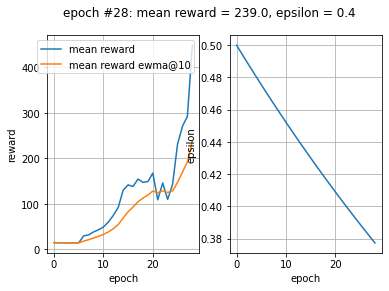

In [58]:
from IPython.display import clear_output


mean_rewards, epsilons = [], []
epsilon = 0.5
for epoch in range(1000):
    session_rewards = [generate_session(env, epsilon, train=True) for _ in range(100)]
    mean_reward = np.mean(session_rewards)
    mean_rewards.append(mean_reward)
    epsilons.append(epsilon)

    if epoch % 5 == 0:
        clear_output(wait=True)
        plot_results(epoch, mean_rewards, epsilons)

    if mean_reward > 300:
        print("You Win!")
        clear_output(wait=True)
        plot_results(epoch, mean_rewards, epsilons)
        break

    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

## How to interpret results

Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

## Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [59]:
import gym.wrappers


with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor, epsilon=0, train=False) for _ in range(100)]

In [63]:
from base64 import b64encode
from pathlib import Path

from IPython.display import HTML


video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)